# 1. Data preparation

In [67]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
dataset = 'picasso_test'
version = ''

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Reading img...
Loading /home/miguel/Projects/uni/data/smlm_3d/picasso_test/training/NPC-A647-3D-BEADS-as-stacks.tif
Loading /home/miguel/Projects/uni/data/smlm_3d/picasso_test/training/NPC-A647-3D-BEADS-as-stacks_locs.csv
using image sharpness
3 emitters before filtering
3 emitters after borders
3 PSFs remaining
Aligning (3, 41, 32, 32) psfs...


  0%|          | 0/2 [00:00<?, ?it/s]

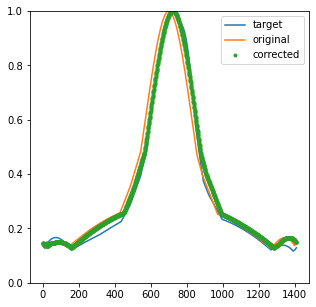

 50%|█████     | 1/2 [00:03<00:03,  3.08s/it]

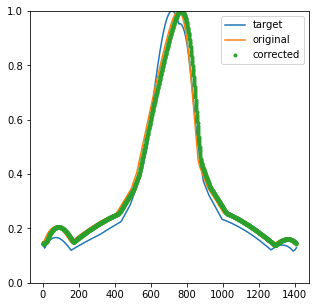

100%|██████████| 2/2 [00:05<00:00,  2.51s/it]


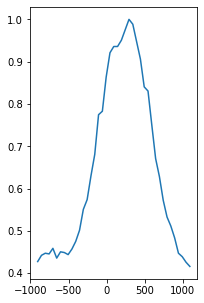

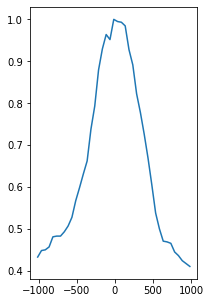

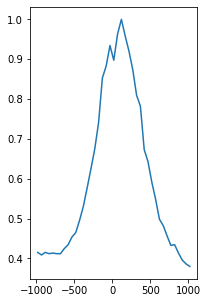

Adding noise
N repeats 10
(913, 32, 32)


In [68]:
%load_ext autoreload
%autoreload 2
from config.datasets import dataset_configs

from config.datasets import dataset_configs
from data.datasets import TrainingDataSet, ExperimentalDataSet, GenericDataSet, MultiTrainingDataset
from workflow_v2 import concat_dataset_features

BOUND = 16
GenericDataSet.bound = BOUND

z_range = 1000

cfg = dataset_configs[dataset]['training']
# cfg['csv'] = cfg['csv'].replace('_filtered', '')
train_dataset = TrainingDataSet(cfg, fit_plane_z=False, lazy=True, transform_data=False, z_range=1000, split_data=True, add_noise=True, filter_emitters_proximity=False)
train_dataset.csv_data = train_dataset.csv_data.iloc[0:3]
train_dataset.prepare_data()
# dataset = '20220506_Miguel_beads_zeiss'
# cfgs = [
#     dataset_configs[dataset]['training_3'],
#     dataset_configs[dataset]['training_4'],
#     dataset_configs[dataset]['training_5']
# ]

# cfg = cfgs[0]
# ds = MultiTrainingDataset(cfgs, fit_plane_z=True, 
#                           filter_emitters_proximity=True, 
#                           transform_data=False, 
#                           z_range=z_range, 
#                           add_noise=4, 
#                           split_data=True, 
#                           normalize_psf=True)

# train_dataset = ds.merge()

# train_dataset.prepare_debug()

In [69]:
import os

if version is not None:
    model_name = f'{dataset}'
model_path = os.path.join('/home/miguel/Projects/uni/phd/smlm_z/final_project/smlm_3d/experiments/model_ckpt', f'{dataset}{version}')
def save_model(model):
    model.save_weights(model_path)
#     model.save(model_path, save_format='h5')
    print(model_path)
    print('Saved model!')

def load_model(model):
    print('Loading model...')
    print(model_path)
    model.load_weights(model_path)
    return model
#     return keras.models.load_model(model_path)


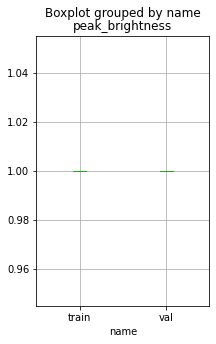

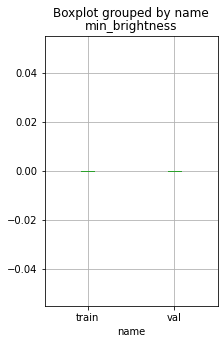

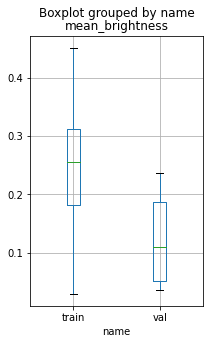

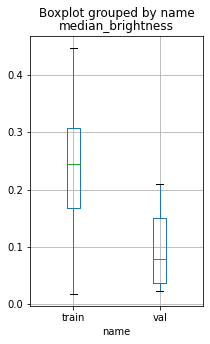

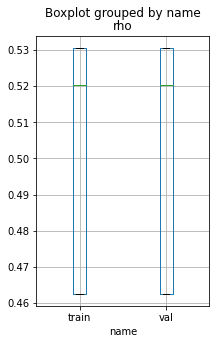

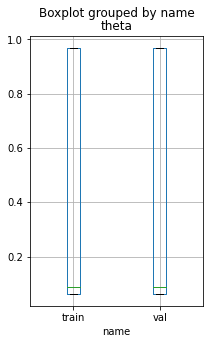

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [3, 5]
def gather_stats(dataset, name, dataset_type='training'):
    records = [] 
    
    if dataset_type == 'training':
        (imgs, coords), _ = dataset
    else:
        imgs, coords = dataset
    
    for img, coord in zip(imgs, coords):
        results = {
            'name': name,
            'peak_brightness': img.max(),
            'min_brightness': img.min(),
            'mean_brightness': img.mean(),
            'median_brightness': np.median(img),
            'rho': coord[0],
            'theta': coord[1],
        }
        records.append(results)
        
    return pd.DataFrame.from_records(records)

if 'all' not in train_dataset.data:
    train = train_dataset.data['train']
    val = train_dataset.data['val']
    
    records = []
    records.append(gather_stats(train, 'train'))
    records.append(gather_stats(val, 'val'))
    
    df = pd.concat(records)
    for col in list(df):
        if col != 'name':
            df.boxplot(by='name', column=col)
    
    

In [71]:
# from scipy.optimize import curve_fit

# def shift_correction(y, y_pred):
#     y_pred = y_pred -  tf.math.reduce_mean(y_pred) +  tf.math.reduce_mean(y)
#     return y_pred


In [72]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import RandomTranslation, GaussianNoise, Normalization, BatchNormalization, ReLU
from tensorflow.keras import Model, Sequential
from tensorflow.keras import layers as Layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, Conv2D

from workflow_v2 import eval_model

SEED = 42
class ResBlock(Model):
    def __init__(self, channels, stride=1, name='ResBlock'):
        super(ResBlock, self).__init__(name=name)
        self.flag = (stride != 1)
        self.conv1 = Conv2D(channels, 3, stride, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(channels, 3, padding='same')
        self.bn2 = BatchNormalization()
        self.relu = ReLU()
        if self.flag:
            self.bn3 = BatchNormalization()
            self.conv3 = Conv2D(channels, 1, stride)

    def call(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        if self.flag:
            x = self.conv3(x)
            x = self.bn3(x)
        x1 = Layers.add([x, x1])
        x1 = self.relu(x1)
        return x1


class ResNet34(Model):
    def __init__(self):
        super(ResNet34, self).__init__(name='ResNet34')
        self.transpose = RandomTranslation(0.1, 0.1)
        self.feature_extraction = Sequential([
            Conv2D(64, 7, 2, padding='same'),
            BatchNormalization(),
            ReLU(),
            MaxPooling2D(3, 2),
            ResBlock(64, name='ResBlock64_1'),
            ResBlock(64, name='ResBlock64_2'),
            ResBlock(64, name='ResBlock64_3'),
            ResBlock(128, 2, name='ResBlock128_1'),
            ResBlock(128, name='ResBlock128_2'),
            ResBlock(128, name='ResBlock128_3'),
            ResBlock(128, name='ResBlock128_4'),
            ResBlock(256, 2, name='ResBlock256_1'),
            ResBlock(256, name='ResBlock256_2'),
            ResBlock(256, name='ResBlock256_3'),
            ResBlock(256, name='ResBlock256_4'),
            ResBlock(256, name='ResBlock256_5'),
            ResBlock(256, name='ResBlock256_6'),
            ResBlock(512, 2, name='ResBlock512_1'),
            ResBlock(512, name='ResBlock512_2'),
            ResBlock(512, name='ResBlock512_3')
        ])
#         self.conv1 = Conv2D(64, 7, 2, padding='same')
#         self.bn = BatchNormalization()
#         self.relu = ReLU()
#         self.mp1 = MaxPooling2D(3, 2)

#         self.conv2_1 = ResBlock(64)
#         self.conv2_2 = ResBlock(64)
#         self.conv2_3 = ResBlock(64)

#         self.conv3_1 = ResBlock(128, 2)
#         self.conv3_2 = ResBlock(128)
#         self.conv3_3 = ResBlock(128)
#         self.conv3_4 = ResBlock(128)

#         self.conv4_1 = ResBlock(256, 2)
#         self.conv4_2 = ResBlock(256)
#         self.conv4_3 = ResBlock(256)
#         self.conv4_4 = ResBlock(256)
#         self.conv4_5 = ResBlock(256)
#         self.conv4_6 = ResBlock(256)

#         self.conv5_1 = ResBlock(512, 2)
#         self.conv5_2 = ResBlock(512)
#         self.conv5_3 = ResBlock(512)

        self.pool = GlobalAveragePooling2D()
        self.fc1 = Dense(1024)
        self.dp1 = Dropout(0.5)
        self.fc2 = Dense(1024)
        self.dp2 = Dropout(0.5)
        self.fc3 = Dense(1)

    def call(self, inp, training):
        x, coords = inp
        
        x = self.transpose(x)
        x = self.feature_extraction(x)
#         x = self.conv1(x)
#         x = self.bn(x)
#         x = self.relu(x)
#         x = self.mp1(x)

#         x = self.conv2_1(x)
#         x = self.conv2_2(x)
#         x = self.conv2_3(x)

#         x = self.conv3_1(x)
#         x = self.conv3_2(x)
#         x = self.conv3_3(x)
#         x = self.conv3_4(x)

#         x = self.conv4_1(x)
#         x = self.conv4_2(x)
#         x = self.conv4_3(x)
#         x = self.conv4_4(x)
#         x = self.conv4_5(x)
#         x = self.conv4_6(x)

#         x = self.conv5_1(x)
#         x = self.conv5_2(x)
#         x = self.conv5_3(x)

        x = self.pool(x)

        # Concat norm X/Y coordinates
        x = tf.concat((x, coords), axis=1)

        x = self.fc1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.fc3(x)
        # Restrict to valid output range [-1000, 1000]    
#         x = tf.tanh(x) * 1000
        return x

#     def test_step(self, data):
#         (img, coords), y = data
#         y_pred = self((img, coords), training=False)

#         shifted_pred = shift_correction(y, y_pred)

#         self.compiled_loss(y, shifted_pred, regularization_losses=self.losses)
#         self.compiled_metrics.update_state(y, shifted_pred)
#         # Return a dict mapping metric names to current value.
#         # Note that it will include the loss (tracked in self.metrics).
#         return {m.name: m.result() for m in self.metrics}
        
            
            
def load_regression_model():

    # model = Sequential()
    # model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    # model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    # model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    # model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    # model.add(Flatten())
    # model.add(Dense(512, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(1, activation='linear'))

    model = ResNet34()
    
#     model = res34()
    model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(learning_rate=0.01, decay=1e-6),metrics=['mean_absolute_error'])
    return model


In [73]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback
def train_model(dataset, val_dataset=None, pretrained_model=None):
    if not val_dataset:
        val_dataset = dataset['val']
#     for k in dataset:
#         imgs = dataset[k][0][0]
#         norm_imgs = imgs / imgs.max(axis=(1, 2))[:, np.newaxis, np.newaxis]
#         dataset[k][0][0] = norm_imgs

    model = pretrained_model or load_regression_model()

    callbacks = [
        ReduceLROnPlateau(
        monitor='loss', factor=0.1, patience=50, verbose=True,
        mode='min', min_delta=1, cooldown=50, min_lr=1e-10,),
#         ReduceLROnPlateau(
#         monitor='val_mean_absolute_error', factor=0.1, patience=50, verbose=True,
#         mode='min', min_delta=1, cooldown=50, min_lr=1e-10,),
        EarlyStopping(monitor='val_mean_absolute_error', patience=500, verbose=True, min_delta=1, restore_best_weights=True),
#         TqdmCallback(verbose=1)
    ]

#     print(dataset['train'][0][0].shape)
#     print(dataset['train'][0][1].shape)
#     print(dataset['train'][1].shape)

    history = model.fit(*dataset['train'], epochs=5000, batch_size=2**15, validation_data=(*val_dataset,), callbacks=callbacks, verbose=True)

    fig, ax1 = plt.subplots()
    ax1.plot(history.history['mean_absolute_error'], label='mse')
    ax1.plot(history.history['val_mean_absolute_error'], label='val_mse')
    ax1.set_yscale('log')
    ax1.legend(loc=1)
    ax2 = ax1.twinx()
    ax2.plot(history.history['lr'], label='lr')
    ax2.legend(loc=0)

    plt.show()
    return model

TRAIN_NEW_MODEL = False

if TRAIN_NEW_MODEL:
    model = train_model(train_dataset.data)
    save_model(model)
else:
    model = load_model(load_regression_model())

tmp_x = train_dataset.data['train'][0][0][0:2], train_dataset.data['train'][0][1][0:2]
model(tmp_x)
print(model.summary())

Loading model...
/home/miguel/Projects/uni/phd/smlm_z/final_project/smlm_3d/experiments/model_ckpt/picasso_test
Model: "ResNet34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_translation (RandomT  multiple                 0         
 ranslation)                                                     
                                                                 
 sequential (Sequential)     (2, 1, 1, 512)            21303936  
                                                                 
 global_average_pooling2d (G  multiple                 0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               multiple                  527360    
                                                                 
 dropout (Dropout)           multiple                  0         
            

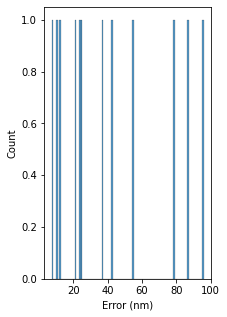

Mean error 41.258672290378136
std error 29.67263813997012
Rows 2 Cols 10 n_spaces 20 n_psfs 12


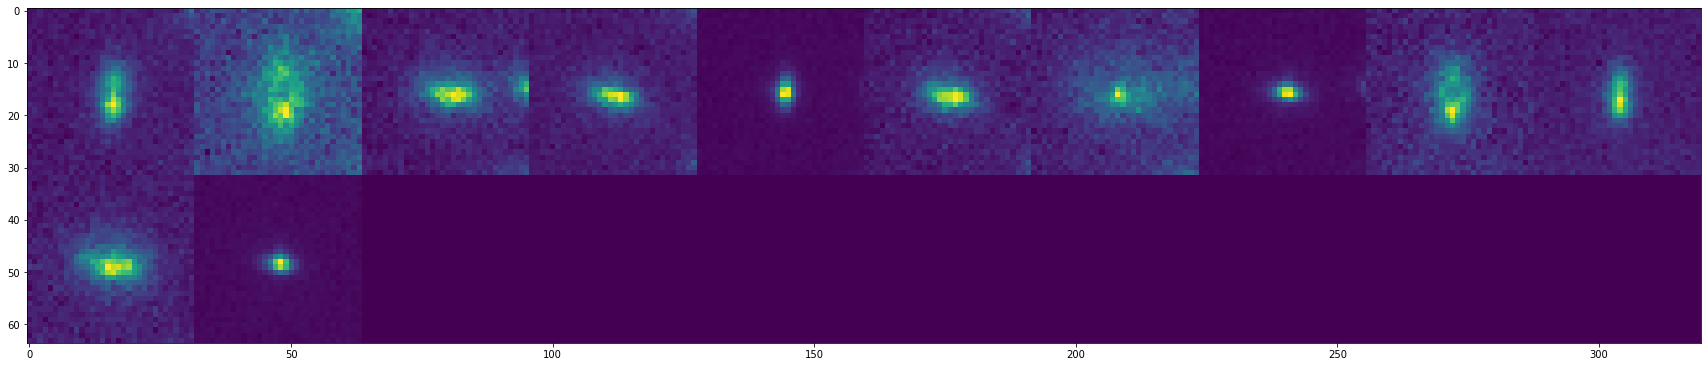